## Exploración de datos

### Analisis de atributos y relaciones con "review"

Los atributos que contienen la palabra "review" se refieren a las reseñas que recibe un juego, tanto en cantidad como en su valoración. El campo game_review_score representa el puntaje promedio de reseñas que tiene un juego, con valores que oscilan entre 0 y 100.

Adicionalmente, existen atributos con el formato review_X, donde X es un múltiplo de 5 entre 5 y 100 (por ejemplo, review_5, review_10, ..., review_100). Cada uno de estos atributos indica la cantidad de reseñas que otorgaron exactamente ese puntaje al juego. El campo review_review_count representa el número total de reseñas recibidas por el juego.

A continuación, se presenta una tabla que agrupa los juegos según intervalos de puntaje promedio (game_review_score) y muestra la cantidad de juegos que caen en cada intervalo. Además, se incluye la cantidad total de juegos que no han recibido ninguna reseña.

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las filas que tengan un puntaje de review válido (eliminar NaN)
df_filtered = df[['game_game_name', 'game_review_score']].copy()

# Crear los intervalos de puntajes (0-10, 10-20, ..., 90-100)
bins = list(range(0, 110, 10))
labels = [f'{i}-{i+10}' for i in range(0, 100, 10)]

# Asignar los juegos a los intervalos
df_filtered['review_interval'] = pd.cut(df_filtered['game_review_score'], bins=bins, labels=labels, right=False)

# Contar cuántos juegos caen en cada intervalo
review_count_by_interval = df_filtered['review_interval'].value_counts().sort_index()

# Contar la cantidad de juegos con 0 reviews
cero_reviews_count = df[df['game_count_review'] == 0].shape[0]

# Crear la tabla
table = pd.DataFrame({
    'Intervalo de Puntaje': review_count_by_interval.index,
    'Cantidad de Juegos': review_count_by_interval.values
})

# Mostrar la tabla
print(table)


print(f"\nCantidad de juegos sin review: {cero_reviews_count}")


  Intervalo de Puntaje  Cantidad de Juegos
0                 0-10               90327
1                10-20                1117
2                20-30                1725
3                30-40                2385
4                40-50                4470
5                50-60                8526
6                60-70               14750
7                70-80               15085
8                80-90                6709
9               90-100                1547

Cantidad de juegos sin review: 90209


Se observa que existe una gran cantidad de juegos no han recibido ninguna review. Incluir estos juegos en el dataset puede resultar problemático si se desea realizar análisis que relacionen el puntaje promedio de reviews con otros atributos. Esto se debe a que, al no tener ninguna reseña, su puntaje promedio se representa como 0, lo cual no refleja una calificación real y puede introducir ruido o sesgos en el análisis. Por lo tanto, puede ser recomendable excluir estos registros en estudios donde las reviews son una variable clave. A continuación se puede apreciar la diferencia entre tener o no los juegos sin reviews.

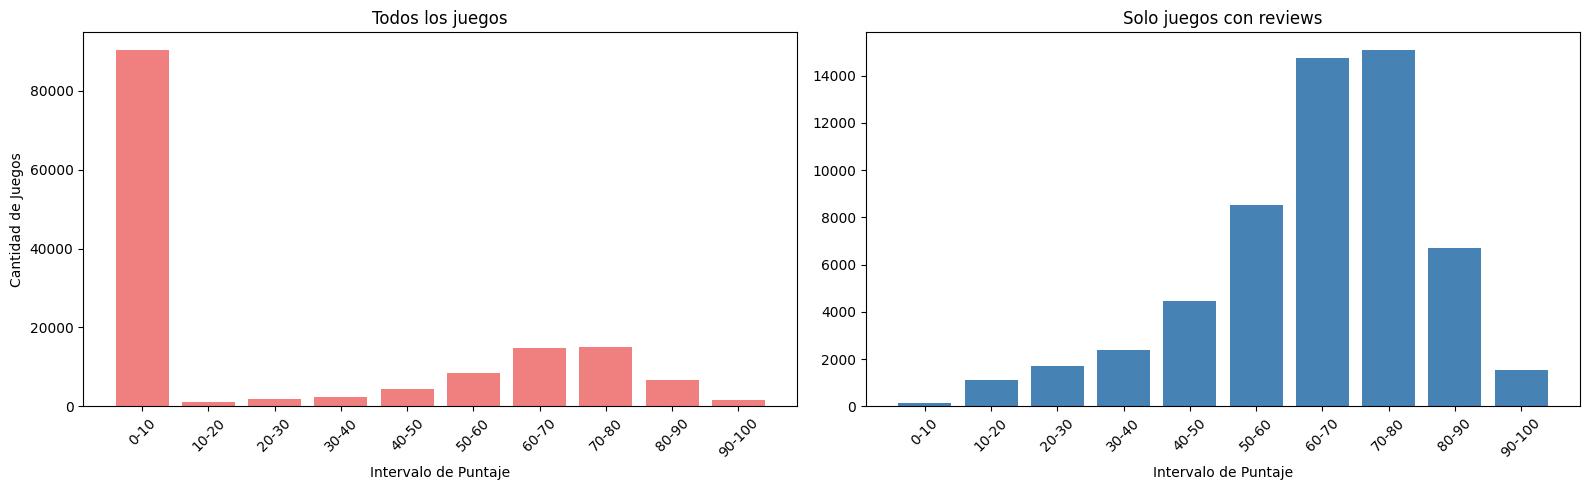

In [102]:
# Crear intervalos de 10 en 10 de 0 a 100
bins = list(range(0, 110, 10))
labels = [f'{i}-{i+10}' for i in range(0, 100, 10)]

# Filtrar columnas necesarias
df_filtered_all = df[['game_game_name', 'game_review_score', 'game_count_review']].copy()

# Tabla con todos los juegos (incluyendo los sin reviews)
df_filtered_all['review_interval'] = pd.cut(df_filtered_all['game_review_score'], bins=bins, labels=labels, right=False)
review_counts_all = df_filtered_all['review_interval'].value_counts().sort_index()

# Tabla sin juegos que no tienen reviews
df_filtered_with_reviews = df_filtered_all[df_filtered_all['game_count_review'] > 0].copy()
df_filtered_with_reviews['review_interval'] = pd.cut(df_filtered_with_reviews['game_review_score'], bins=bins, labels=labels, right=False)
review_counts_filtered = df_filtered_with_reviews['review_interval'].value_counts().sort_index()

# Crear la figura con tamaños personalizados para los gráficos
fig = plt.figure(figsize=(16, 5))

# Subgráfico 1: todos los juegos
ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(review_counts_all.index.astype(str), review_counts_all.values, color='lightcoral')
ax1.set_title('Todos los juegos')
ax1.set_xlabel('Intervalo de Puntaje')
ax1.set_ylabel('Cantidad de Juegos')
ax1.tick_params(axis='x', rotation=45)

# Subgráfico 2: solo juegos con reviews
ax2 = fig.add_subplot(1, 2, 2)
ax2.bar(review_counts_filtered.index.astype(str), review_counts_filtered.values, color='steelblue')
ax2.set_title('Solo juegos con reviews')
ax2.set_xlabel('Intervalo de Puntaje')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Una relación interesante a analizar es como se comportan las reviews con respecto al tiempo promedio de juego, para ello se puede analizar el siguiente grafico.

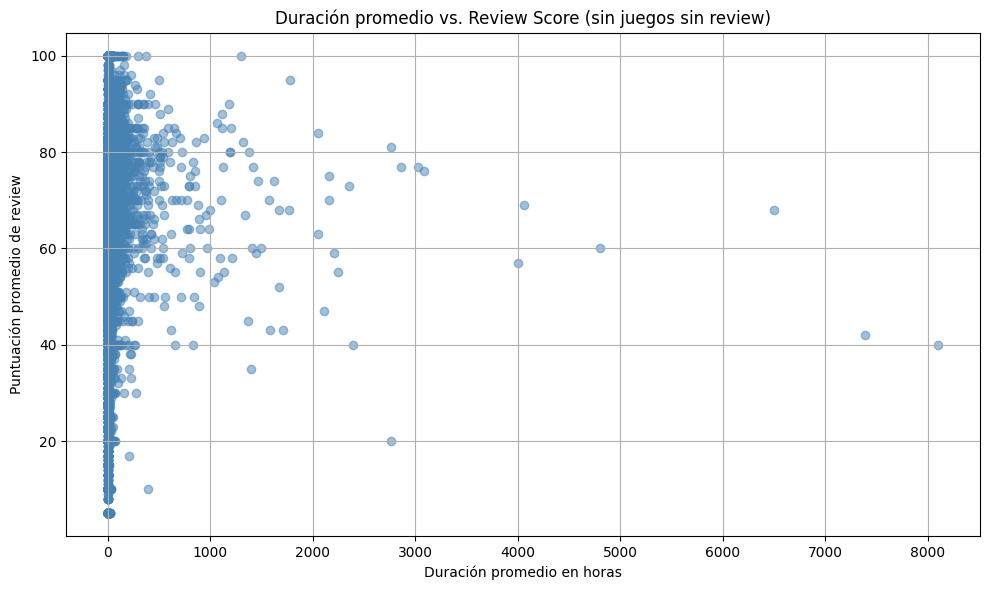

In [103]:
# Filtrar filas con valores nulos en las columnas necesarias y sin juegos con 0 reviews
df_filtered = df[['game_game_name', 'game_comp_all_avg', 'game_review_score', 'game_count_review']].dropna().copy()
df_filtered = df_filtered[df_filtered['game_count_review'] > 0]

# Convertir segundos a horas para facilitar la interpretación
df_filtered['game_comp_all_avg_hrs'] = df_filtered['game_comp_all_avg'] / 3600

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(
    df_filtered['game_comp_all_avg_hrs'],
    df_filtered['game_review_score'],
    alpha=0.5,
    color='steelblue'
)
plt.xlabel('Duración promedio en horas')
plt.ylabel('Puntuación promedio de review')
plt.title('Duración promedio vs. Review Score (sin juegos sin review)')
plt.grid(True)
plt.tight_layout()
plt.show()


Se puede ver inmediatamente que existen outliers, entonces veamos la distribucion de los tiempos de termino.

In [104]:
# Filtrar filas con duración y con al menos una review
df_filtered = df[['game_game_name', 'game_comp_all_avg', 'game_count_review']].dropna().copy()
df_filtered = df_filtered[df_filtered['game_count_review'] > 0]

# Convertir duración de segundos a horas
df_filtered['game_comp_all_avg_hrs'] = df_filtered['game_comp_all_avg'] / 3600

# Definir los intervalos, incluyendo mayores de 1000 horas
bins = [0, 50, 100, 200, 500, 1000, float('inf')]
labels = ['0-50 hrs', '50-100 hrs', '100-200 hrs', '200-500 hrs', '500-1000 hrs', '>1000 hrs']

# Crear la columna de intervalos
df_filtered['duration_range'] = pd.cut(df_filtered['game_comp_all_avg_hrs'], bins=bins, labels=labels, right=False)

# Contar cuántos juegos hay en cada intervalo
count_per_range = df_filtered['duration_range'].value_counts().sort_index()

# Mostrar resultados
print("Cantidad de juegos por intervalo de duración (Main Story en horas), excluyendo juegos sin reviews:")
print(count_per_range)


Cantidad de juegos por intervalo de duración (Main Story en horas), excluyendo juegos sin reviews:
duration_range
0-50 hrs        55002
50-100 hrs       1488
100-200 hrs       462
200-500 hrs       192
500-1000 hrs       67
>1000 hrs          54
Name: count, dtype: int64


 Como se nota de forma sencilla que la concentración de juegos es principalmente en el primer intervalo se van a eliminar outliers utilizando solo el 90% menor de los datos, lo que genera el proximo grafico donde ya se puede notar cierta agrupación entre puntos.

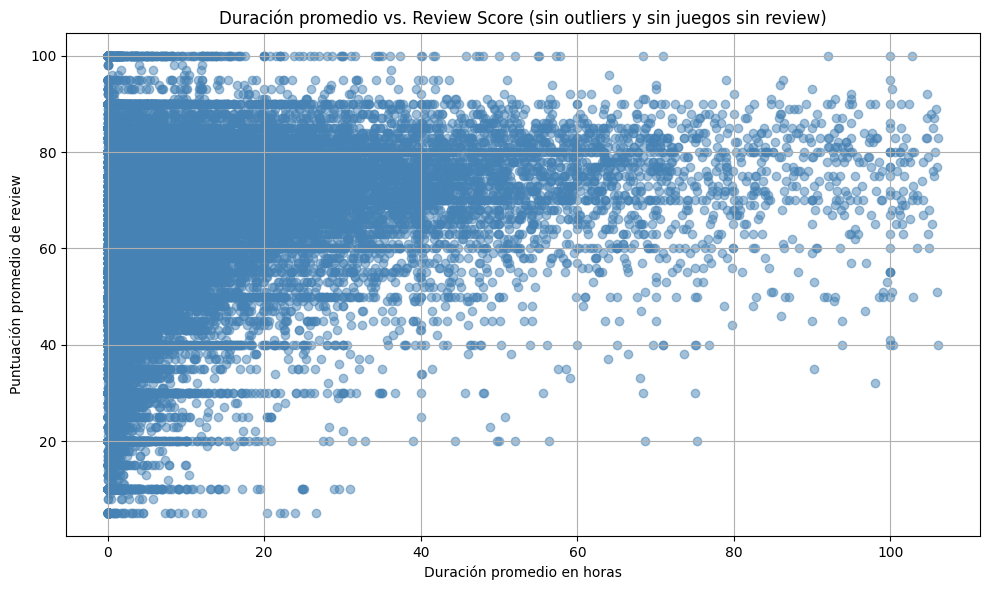

In [105]:
# Función para remover outliers usando IQR (con Q3 en el percentil 99)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filtrar filas con valores nulos y eliminar juegos sin reviews
df_filtered = df[['game_game_name', 'game_comp_all_avg', 'game_review_score', 'game_count_review']].dropna().copy()
df_filtered = df_filtered[df_filtered['game_count_review'] > 0]

# Convertir duración de segundos a horas
df_filtered['game_comp_all_avg_hrs'] = df_filtered['game_comp_all_avg'] / 3600

# Eliminar outliers en duración y review score
df_no_outliers = remove_outliers_iqr(df_filtered, 'game_comp_all_avg_hrs')
df_no_outliers = remove_outliers_iqr(df_no_outliers, 'game_review_score')

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(
    df_no_outliers['game_comp_all_avg_hrs'],
    df_no_outliers['game_review_score'],
    alpha=0.5,
    color='steelblue'
)
plt.xlabel('Duración promedio en horas')
plt.ylabel('Puntuación promedio de review')
plt.title('Duración promedio vs. Review Score (sin outliers y sin juegos sin review)')
plt.grid(True)
plt.tight_layout()
plt.show()
